# Final Project: Daniel Bishop

## Research Question 1

Given the known link between one subtropical High and southeastern United States *__fall__* precipitation trend, can we identify a global pattern in regional *__fall__* precipitation and subtropical High pressure intensity?

    Hypothesis: Global precipitation increases will exist along the western edge of intensifying subtropical Highs.

## Part 1: Read in Data

In [1]:
#Import packages (xarray, numpy, matplotlib, cartopy)
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

#OPeNDAP (read in) GPCC Precipitation & NCEP-NCAR Reanalysis Sea-Level Pressure data
#1901-2013 GPCC Monthly Precipitation
ds_prec = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/gpcc/full_v7/precip.mon.total.1x1.v7.nc')
#1948-2017 Monthly Sea-Level Pressure
ds_slp = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/slp.mon.mean.nc')

#Read in land-sea mask data from NCEP, ignoring warnings (indicates time is unreadable)
import warnings
warnings.filterwarnings('ignore')  #Ignore warnings
ds_lnd = xr.open_dataset('land.nc')  #NCEP Land-Sea Mask
warnings.filterwarnings('default')  #Turn warnings back on
lndAv = ds_lnd.land.mean(dim='time')  #Pull out lat/lon land mask

Quickly check variable names and units:

In [2]:
#Note units of each variable
print('Precipitation long name: '+ds_prec.precip.attrs['long_name'])
print('Precipitation units: '+ds_prec.precip.attrs['units'])
print('')
print('Sea-level pressure long name: '+ds_slp.slp.attrs['long_name'])
print('Sea-level pressure units: '+ds_slp.slp.attrs['units'])

Precipitation long name: GPCC Monthly total of precipitation
Precipitation units: mm

Sea-level pressure long name: Sea Level Pressure
Sea-level pressure units: millibars


## Part 2: Data preparation

First, I need to pull out fall-season (__*Northern Hemisphere only, at least for now*__) precipitation and sea-level-pressure for overlapping years in these two datasets (1948-2013):

In [34]:
#Isolate precipitation and sea-level pressure (SLP) variables
prec0 = ds_prec.precip
slp0 = ds_slp.slp

#Pull out fall season (1948-2013) only
#Sum of precipitation during fall season
precSON = prec0.where((prec0['time.season']=='SON') & (prec0['time.year']<=2013) 
                      & (prec0['time.year']>=1948),drop=True).groupby('time.year').sum(dim='time')
#Mean of SLP during fall season
slpSON = slp0.where((slp0['time.season']=='SON') & (slp0['time.year']<=2013),drop=True).groupby('time.year').mean(dim='time')

Next, I can plot global means to examine the accuracy of my input datasets:

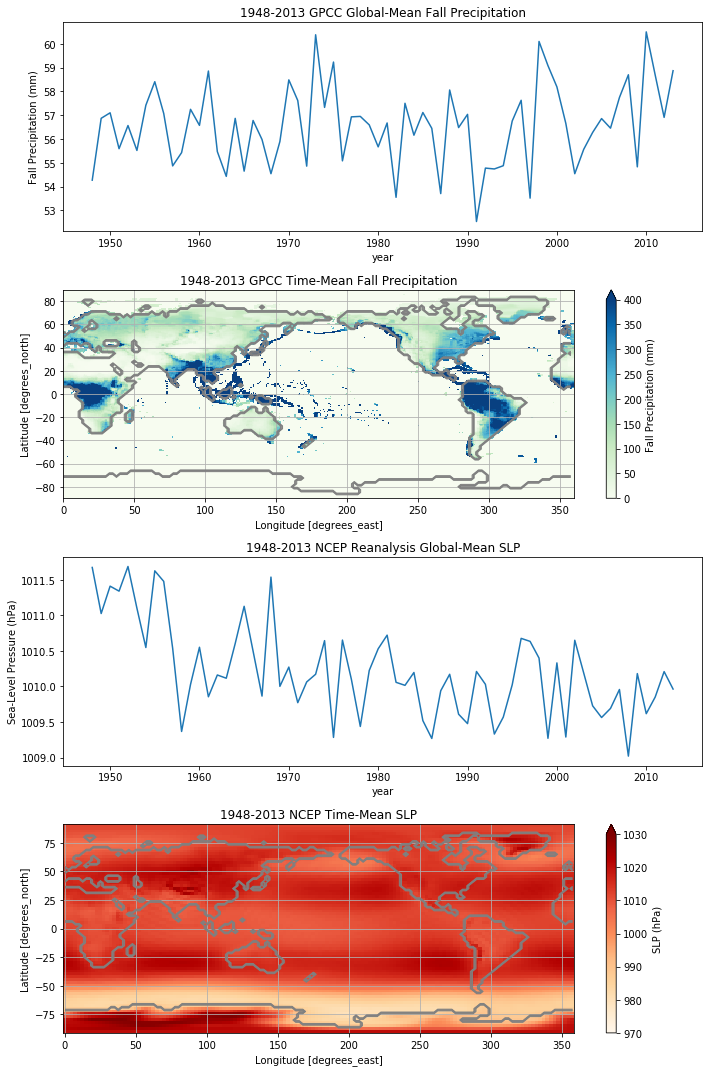

In [4]:
#Fall season plots of precipitation and SLP
fig = plt.figure(figsize=(10,15))  #Initialize figure size
#Initialize 4 subplots, assign to variable name ax
ax = fig.subplots(nrows=4)

#Panel plots 1 & 2 (precipitation)
precSON.mean(dim=['lat','lon']).plot(ax=ax[0]);  #Global spatial mean of fall precip
precSON.mean(dim='year').plot(ax=ax[1],cmap='GnBu',vmin=0
                              ,vmax=400,cbar_kwargs={'label': 'Fall Precipitation (mm)'});  #Time-mean of fall precip
lndAv.plot.contour(ax=ax[1],colors='grey',linewidths=1);  #Land area contours

#Panel plots 3 & 4 (SLP)
slpSON.mean(dim=['lat','lon']).plot(ax=ax[2]);  #Global spatial mean of SLP
slpSON.mean(dim='year').plot(ax=ax[3],cmap='OrRd',vmin=970,
                             vmax=1030,cbar_kwargs={'label': 'SLP (hPa)'});  #Time-mean of SLP
lndAv.plot.contour(ax=ax[3],colors='grey',linewidths=1);  #Land area contours

#Add titles, y-axis labels, map grids
ax[0].set_title('1948-2013 GPCC Global-Mean Fall Precipitation');
ax[0].set_ylabel('Fall Precipitation (mm)');
ax[1].set_title('1948-2013 GPCC Time-Mean Fall Precipitation');
ax[1].grid()
ax[2].set_title('1948-2013 NCEP Reanalysis Global-Mean SLP');
ax[2].set_ylabel('Sea-Level Pressure (hPa)');
ax[3].set_title('1948-2013 NCEP Time-Mean SLP');
ax[3].grid()

plt.tight_layout()  #Space subplots adequately

## Part 3: Linear Trends
Prepare data and calculate trends:

In [6]:
#Take raw precipitation and standardize SLP by grid cell
precSON_z = precSON

slpAv = slpSON.mean(dim='year')
slpSD = slpSON.std(dim='year')
slpSON_z = (slpSON-slpAv)/slpSD

#Calculate global trends of precipitation
yrs = precSON_z.year.values  #Isolate years (1-66)
precFit = precSON_z.values.reshape(len(yrs),-1)  #Reshape precSON_z to shape of years
#Fit linear regression (1 degree of fitting polynomial = linear regression (y=ax+b))
precTr = np.polyfit(x=yrs,y=precFit,deg=1)
#Pull trend coefficients (index=0) and reshape to original shape (lat/lon coordinates)
coPrec = precTr[0,:].reshape(precSON_z.values.shape[1],precSON_z.values.shape[2])

#Calculate global trends of SLP
yrs = slpSON_z.year.values  #Isolate years (1-66)
slpFit = slpSON_z.values.reshape(len(yrs),-1)  #Reshape slpSON_z to shape of years
#Fit linear regression (1 degree of fitting polynomial = linear regression (y=ax+b))
slpTr = np.polyfit(x=yrs,y=slpFit,deg=1)
#Pull trend coefficients (index=0) and reshape to original shape (lat/lon coordinates)
coSLP = slpTr[0,:].reshape(slpSON_z.values.shape[1],slpSON_z.values.shape[2])


Sea-level pressure is standardized given high variance near the equator/ITCZ. If I did not do this, the large trends near the equator would make it difficult to see the SLP trends in the subtropics and midlatitude regions.

Next, I can plot the trend maps and identify prominent regional precipitation trends:

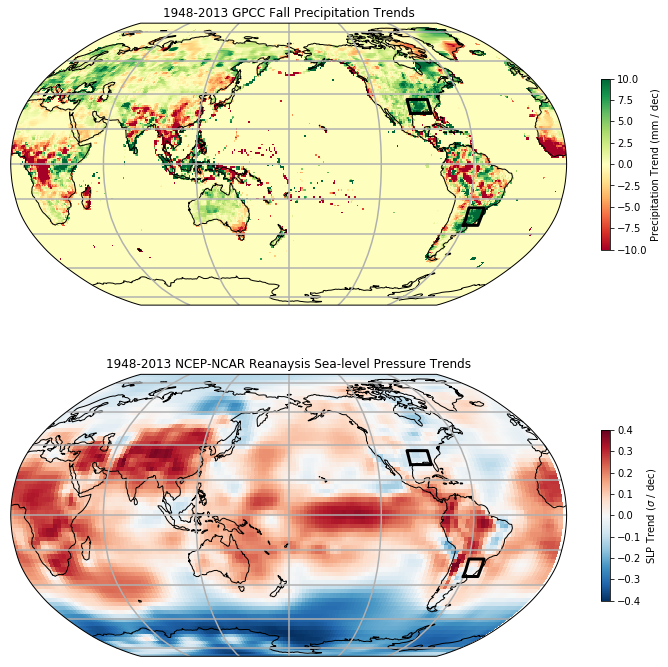

In [31]:
#Fall season trend plots for precipitation and SLP
fig = plt.figure(figsize=(10,10))  #Initialize figure size
#Initialize 2 subplots, assign to variable names ax
ax = fig.subplots(nrows=2,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})  #Robinson projection used

#Plot colormap of precipitation trends (mm/decade)
cbp1 = ax[0].pcolormesh(precSON_z.lon.values,precSON_z.lat.values,10*coPrec,
                        cmap='RdYlGn',vmin=-10,vmax=10,transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add boxes outlining regions of large positive precipitation trends
ax[0].plot([360-98,360-84,360-84,360-98,360-98],[29,29,37,37,29],'k-',linewidth=3,transform=ccrs.PlateCarree())
ax[0].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-',linewidth=3,transform=ccrs.PlateCarree())
#Add and format colorbar
cbar1 = fig.colorbar(cbp1,ax=ax[0],shrink=.5);
cbar1.set_label('Precipitation Trend (mm / dec)')

#Plot colormap of SLP trends (standard deviation/decade)
cbp2 = ax[1].pcolormesh(slpSON_z.lon.values,slpSON_z.lat.values,10*coSLP,
                        cmap='RdBu_r',vmin=-.4,vmax=.4,transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add boxes outlining regions of large positive precipitation trends
ax[1].plot([360-98,360-84,360-84,360-98,360-98],[29,29,37,37,29],'k-',linewidth=3,transform=ccrs.PlateCarree())
ax[1].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-',linewidth=3,transform=ccrs.PlateCarree())
#Add and format colorbar
cbar2 = fig.colorbar(cbp2,ax=ax[1],shrink=.5);
cbar2.set_label(r'SLP Trend ($\sigma$ / dec)')  #Note TeX symbol used for sigma (standard deviation)

ax[0].coastlines()  #Add coastlines
ax[1].coastlines()  #Add coastlines
ax[0].gridlines(linewidth=1.5);  #Add gridlines
ax[1].gridlines(linewidth=1.5);  #Add gridlines
#Add titles
ax[0].set_title('1948-2013 GPCC Fall Precipitation Trends');
ax[1].set_title('1948-2013 NCEP-NCAR Reanaysis Sea-level Pressure Trends');

plt.tight_layout()  #Space subplots adequately

There are clear precipitation trends at similar latitudes over North and South America: southeastern US and portions of Brazil-Uruguay-Argentina. These regions fall in areas with increasing pressure gradients, which indicates stronger circulation and possible increases in low-level moisture transport into each region.

## Part 4: Correlations
So what is causing these large fall precipitation trends in the North and South America? We can investigate by calculating correlations between regionally-averaged fall precipitation and global SLP:

In [20]:
#Calculate correlations between areas of high precipitation trends and SLP

#Slice out regional averages for precipitation for southeastern US (SEUS) and South America (SA)
precSEUS = precSON_z.sel(lon=slice(262,276),lat=slice(37,29)).mean(dim=['lat','lon'])
precSA = precSON_z.sel(lon=slice(300,310),lat=slice(-25,-35)).mean(dim=['lat','lon'])

#Create empty SEUS Data Array to store correlation coefficients
corrSEUS = xr.DataArray(np.ones((slpSON_z.shape[1],slpSON_z.shape[2])),dims=['lat', 'lon'],
                  coords={'lat': slpSON_z.lat.values,
                         'lon': slpSON_z.lon.values},)

#Loop through Data Array to calculate correlations for each grid cell in SLP data
for row in np.arange(0,slpSON_z.shape[1]):  #Shape of latitude
    for col in np.arange(0,slpSON_z.shape[2]):  #Shape of longitude
        corrSEUS.values[row,col] = np.corrcoef(precSEUS.values,slpSON_z.values[:,row,col])[0,1]  #Correlation coefficient

#Create empty SA Data Array to store correlation coefficients
corrSA = xr.DataArray(np.ones((slpSON_z.shape[1],slpSON_z.shape[2])),dims=['lat','lon'],
                  coords={'lat': slpSON_z.lat.values,
                         'lon': slpSON_z.lon.values},)

#Loop through Data Array to calculate correlations for each grid cell in SLP data
for row in np.arange(0,slpSON_z.shape[1]):  #Shape of latitude
    for col in np.arange(0,slpSON_z.shape[2]):  #Shape of longitude
        corrSA.values[row,col] = np.corrcoef(precSA.values,slpSON_z.values[:,row,col])[0,1]  #Correlation coefficient


Next, I can plot the correlation maps to look for regional dependencies on SLP that align with trend maps above:

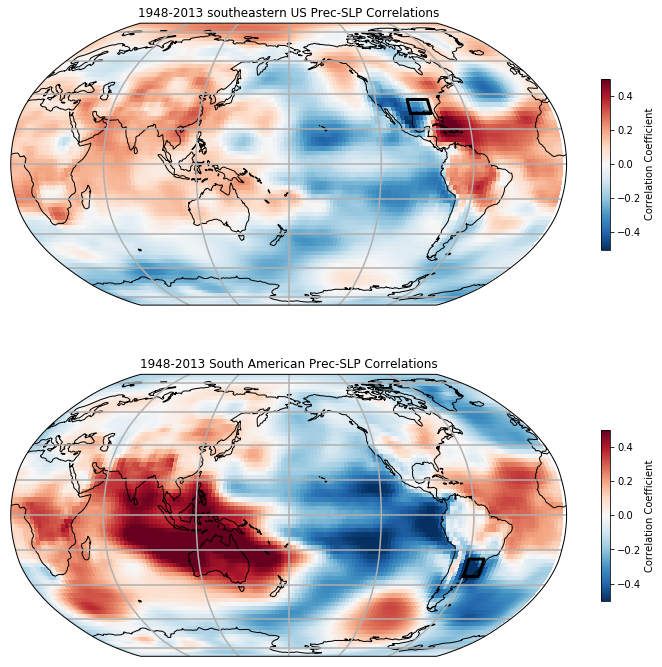

In [33]:
#Fall correlation plots for precipitation and SLP
fig = plt.figure(figsize=(10,10))  #Initialize figure size
#Initialize 2 subplots, assign to variable names ax
ax = fig.subplots(nrows=2,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})  #Robinson projection used

#Plot colormap of southeastern US correlations
cbp1 = ax[0].pcolormesh(corrSEUS.lon.values,corrSEUS.lat.values,corrSEUS.values,vmin=-.5,vmax=.5,
                        cmap='RdBu_r',transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add box outlining SE-US region
ax[0].plot([360-98,360-84,360-84,360-98,360-98],[29,29,37,37,29],'k-',linewidth=3,transform=ccrs.PlateCarree());
#Add and format colorbar
cbar1 = fig.colorbar(cbp1,ax=ax[0],shrink=.5);
cbar1.set_label('Correlation Coefficient')

#Plot colormap of South American correlations
cbp2 = ax[1].pcolormesh(corrSA.lon.values,corrSA.lat.values,corrSA.values,vmin=-.5,vmax=.5,
                        cmap='RdBu_r',transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add box outlining SA region
ax[1].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-',linewidth=3,transform=ccrs.PlateCarree());
#Add and format colorbar
cbar2 = fig.colorbar(cbp2,ax=ax[1],shrink=.5);
cbar2.set_label('Correlation Coefficient')

ax[0].coastlines()  #Add coastlines
ax[1].coastlines()  #Add coastlines
ax[0].gridlines(linewidth=1.5);  #Add gridlines
ax[1].gridlines(linewidth=1.5);  #Add gridlines
#Add titles
ax[0].set_title('1948-2013 southeastern US Prec-SLP Correlations');
ax[1].set_title('1948-2013 South American Prec-SLP Correlations');

plt.tight_layout()  #Space subplots adequately

These results suggest that, as I knew previously, that the interannual variability of southeastern US precipitation was linked to the zonal pressure gradient over the Gulf of Mexico, primarily via increases in SLP over an area representing the western edge of the North Atlantic subtropical High (top panel).

Over South America, however, the interannual variability in precipitation appears to be linked more closely to ENSO in the tropical Pacific (negatively) and the eastern Indian Ocean (positively), an area that has had increased SLP during this time. There appears to be a weaker relationship with the tropical and subtropical Atlantic, as well.

## Part 5: Southern Hemisphere Fall

If this is a global phenomenon in the __*fall*__ season only, **southern hemisphere** subtropical highs would exhibit sea-level pressure trends in **southern hemisphere** fall (northern hemisphere spring): March-May. If this were occurring, there could be reason to investigate the impacts of global anthropogenic forcing on global subtropical Highs.

First, I'll pull out southern hemisphere spring precipitation and SLP:

In [35]:
#Pull out southern hemisphere spring season only
precMAM = prec0.where((prec0['time.season']=='MAM') & (prec0['time.year']<=2013) 
                      & (prec0['time.year']>=1948),drop=True).groupby('time.year').sum(dim='time')
slpMAM = slp0.where((slp0['time.season']=='MAM') & (slp0['time.year']<=2013) 
                      & (slp0['time.year']>=1948),drop=True).groupby('time.year').mean(dim='time')

Prepare data and calculate trends again:

In [37]:
#Take raw precipitation and standardize SLP by grid cell
precMAM_z = precMAM

slpAv = slpMAM.mean(dim='year')
slpSD = slpMAM.std(dim='year')
slpMAM_z = (slpMAM-slpAv)/slpSD

#Calculate global trends of precipitation
yrs = precMAM_z.year.values  #Isolate years (1-66)
precFit = precMAM_z.values.reshape(len(yrs),-1)  #Reshape precSON_z to shape of years
#Fit linear regression (1 degree of fitting polynomial = linear regression (y=ax+b))
precTr = np.polyfit(x=yrs,y=precFit,deg=1)
#Pull trend coefficients (index=0) and reshape to original shape (lat/lon coordinates)
coPrec = precTr[0,:].reshape(precMAM_z.values.shape[1],precMAM_z.values.shape[2])

#Calculate global trends of SLP
yrs = slpMAM_z.year.values  #Isolate years (1-66)
slpFit = slpMAM_z.values.reshape(len(yrs),-1)  #Reshape slpSON_z to shape of years
#Fit linear regression (1 degree of fitting polynomial = linear regression (y=ax+b))
slpTr = np.polyfit(x=yrs,y=slpFit,deg=1)
#Pull trend coefficients (index=0) and reshape to original shape (lat/lon coordinates)
coSLP = slpTr[0,:].reshape(slpMAM_z.values.shape[1],slpMAM_z.values.shape[2])

Next, I can plot the trend maps and identify prominent regional precipitation trends:

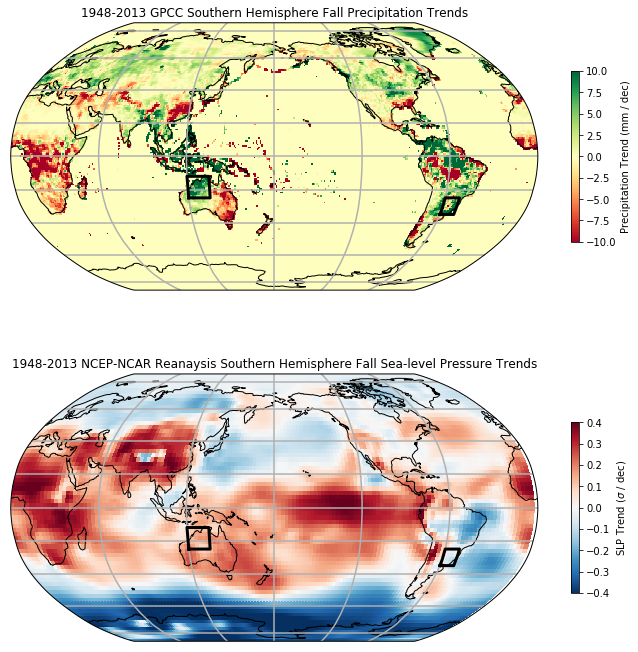

In [46]:
#Fall season trend plots for precipitation and SLP
fig = plt.figure(figsize=(10,10))  #Initialize figure size
#Initialize 2 subplots, assign to variable names ax
ax = fig.subplots(nrows=2,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})  #Robinson projection used

#Plot colormap of precipitation trends (mm/decade)
cbp1 = ax[0].pcolormesh(precMAM_z.lon.values,precMAM_z.lat.values,10*coPrec
                        ,cmap='RdYlGn',vmin=-10,vmax=10,transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add boxes outlining regions of large positive precipitation trends
ax[0].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-',linewidth=3,transform=ccrs.PlateCarree())
ax[0].plot([120,135,135,120,120],[-25,-25,-12,-12,-25],'k-',linewidth=3,transform=ccrs.PlateCarree())
#Add and format colorbar
cbar1 = fig.colorbar(cbp1,ax=ax[0],shrink=.5);
cbar1.set_label('Precipitation Trend (mm / dec)')

#Plot colormap of SLP trends (standard deviation/decade)
cbp2 = ax[1].pcolormesh(slpMAM_z.lon.values,slpMAM_z.lat.values,10*coSLP,
                        cmap='RdBu_r',vmin=-.4,vmax=.4,transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add boxes outlining regions of large positive precipitation trends
ax[1].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-',linewidth=3,transform=ccrs.PlateCarree())
ax[1].plot([120,135,135,120,120],[-25,-25,-12,-12,-25],'k-',linewidth=3,transform=ccrs.PlateCarree())
#Add and format colorbar
cbar2 = fig.colorbar(cbp2,ax=ax[1],shrink=.5);
cbar2.set_label(r'SLP Trend ($\sigma$ / dec)')  #Note TeX symbol used for sigma (standard deviation)

ax[0].coastlines()  #Add coastlines
ax[1].coastlines()  #Add coastlines
ax[0].gridlines(linewidth=1.5);  #Add gridlines
ax[1].gridlines(linewidth=1.5);  #Add gridlines
#Add titles
ax[0].set_title('1948-2013 GPCC Southern Hemisphere Fall Precipitation Trends');
ax[1].set_title('1948-2013 NCEP-NCAR Reanaysis Southern Hemisphere Fall Sea-level Pressure Trends');

plt.tight_layout()  #Space subplots adequately

There are notable precipitation trends at over northwestern  Australia and a localized coastal maximum over southeastern South America.

These regions, however, do not fall in areas with increasing pressure gradients over their moisture sources, which indicates that subtropical High intensification may not play a direct role.

Nevertheless, I can check the correlations for these regions:

In [47]:
#Calculate correlations between areas of high precipitation trends and SLP

#Slice out regional averages for precipitation for Australia (Aus) and South America (SA)
precAus = precMAM_z.sel(lon=slice(120,135),lat=slice(-12,-25)).mean(dim=['lat','lon'])
precSA = precMAM_z.sel(lon=slice(300,310),lat=slice(-25,-35)).mean(dim=['lat','lon'])

#Create empty Aus Data Array to store correlation coefficients
corrAus = xr.DataArray(np.ones((slpMAM_z.shape[1],slpMAM_z.shape[2])),dims=['lat','lon'],
                  coords={'lat': slpMAM_z.lat.values,
                         'lon': slpMAM_z.lon.values},)

#Loop through Data Array to calculate correlations for each grid cell in SLP data
for row in np.arange(0,slpMAM_z.shape[1]):
    for col in np.arange(0,slpMAM_z.shape[2]):
        corrAus.values[row,col] = np.corrcoef(precAus.values,slpMAM_z.values[:,row,col])[0,1]

#Create empty SA Data Array to store correlation coefficients
corrSA = xr.DataArray(np.ones((slpMAM_z.shape[1],slpMAM_z.shape[2])),dims=['lat','lon'],
                  coords={'lat': slpMAM_z.lat.values,
                         'lon': slpMAM_z.lon.values},)

#Loop through Data Array to calculate correlations for each grid cell in SLP data
for row in np.arange(0,slpMAM_z.shape[1]):
    for col in np.arange(0,slpMAM_z.shape[2]):
        corrSA.values[row,col] = np.corrcoef(precSA.values,slpMAM_z.values[:,row,col])[0,1]

And plot the correlations, once again:

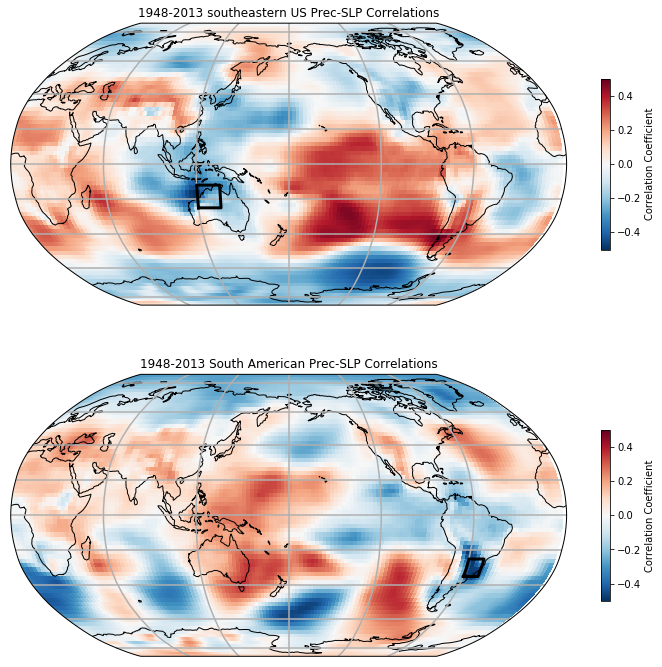

In [48]:
#Southern Hemisphere Fall correlation plots for precipitation and SLP
fig = plt.figure(figsize=(10,10))  #Initialize figure size
#Initialize 2 subplots, assign to variable names ax
ax = fig.subplots(nrows=2,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})  #Robinson projection used

#Plot colormap of Australia correlations
cbp1 = ax[0].pcolormesh(corrAus.lon.values,corrAus.lat.values,corrAus.values,vmin=-.5,vmax=.5,
                        cmap='RdBu_r',transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add box outlining Aus region
ax[0].plot([120,135,135,120,120],[-25,-25,-12,-12,-25],'k-',linewidth=3,transform=ccrs.PlateCarree())
#Add and format colorbar
cbar1 = fig.colorbar(cbp1,ax=ax[0],shrink=.5);
cbar1.set_label('Correlation Coefficient')

#Plot colormap of South American correlations
cbp2 = ax[1].pcolormesh(corrSA.lon.values,corrSA.lat.values,corrSA.values,vmin=-.5,vmax=.5,
                        cmap='RdBu_r',transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add box outlining SA region
ax[1].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-',linewidth=3,transform=ccrs.PlateCarree())
#Add and format colorbar
cbar2 = fig.colorbar(cbp2,ax=ax[1],shrink=.5);
cbar2.set_label('Correlation Coefficient')

ax[0].coastlines()  #Add coastlines
ax[1].coastlines()  #Add coastlines
ax[0].gridlines(linewidth=1.5);  #Add gridlines
ax[1].gridlines(linewidth=1.5);  #Add gridlines
#Add titles
ax[0].set_title('1948-2013 Australian Prec-SLP Correlations');
ax[1].set_title('1948-2013 South American Prec-SLP Correlations');

plt.tight_layout()  #Space subplots adequately

Over both Australia and South America, the correlations express no link to respective subtropical Highs to the east. This suggests, at least initially, that there is little reason to believe the __*fall*__ subtropical High intensification is a global phenomena.

A far more in-depth analysis would be needed to assess the immediate drivers of regional precipitation trends in the regions not impacted by increases in SLP gradients via subtropical High intensification.

## Research Question 2

If a global pattern exists, can we link the subtropical High intensification with global sea-surface temperatures or surface air temperatures?

    Hypothesis: Global increases in subtropical High intensification will be linked to warming
    temperatures globally, although more work will likely be needed to disentangle concurrent
    trends that likely drive the increased correlations.

While I was not able to find any preliminary evidence of global subtropical High intensification, it would be interesting to take a look at the two *__Northern Hemisphere fall__* regions and evaluate their relationship with global sea-surface temperatures.

First, I prepare HadISST fall sea-surface temperatures (SSTs):

In [51]:
#OPeNDAP (read in) Hadley Centre SSTs
#1948-2013 HadISST Monthly SST
ds_sst = xr.open_dataset('https://oceanwatch.pfeg.noaa.gov/thredds/dodsC/HadleyCenter/HadISST')
sst0 = ds_sst.sst
sstSON_z = sst0.where((sst0['time.season']=='MAM') & (sst0['time.year']<=2013) 
                      & (sst0['time.year']>=1948),drop=True).groupby('time.year').mean(dim='time')

Calculate correlations again (regional mean fall precipitation with global SSTs):

In [54]:
#Calculate correlations between areas of high precipitation trends and SST

#Slice out regional averages for precipitation for southeastern US (SEUS) and South America (SA)
precSEUS = precSON_z.sel(lon=slice(262,276),lat=slice(37,29)).mean(dim=['lat','lon'])
precSA = precSON_z.sel(lon=slice(300,310),lat=slice(-25,-35)).mean(dim=['lat','lon'])

#Create empty SEUS Data Array to store correlation coefficients
corrSEUS = xr.DataArray(np.ones((sstSON_z.shape[1],sstSON_z.shape[2])),dims=['lat', 'lon'],
                  coords={'lat': sstSON_z.latitude.values,
                         'lon': sstSON_z.longitude.values},)

#Loop through Data Array to calculate correlations for each grid cell in SLP data
for row in np.arange(0,sstSON_z.shape[1]):  #Shape of latitude
    for col in np.arange(0,sstSON_z.shape[2]):  #Shape of longitude
        corrSEUS.values[row,col] = np.corrcoef(precSEUS.values,sstSON_z.values[:,row,col])[0,1]  #Correlation coefficient

#Create empty SA Data Array to store correlation coefficients
corrSA = xr.DataArray(np.ones((sstSON_z.shape[1],sstSON_z.shape[2])),dims=['lat','lon'],
                  coords={'lat': sstSON_z.latitude.values,
                         'lon': sstSON_z.longitude.values},)

#Loop through Data Array to calculate correlations for each grid cell in SLP data
for row in np.arange(0,sstSON_z.shape[1]):  #Shape of latitude
    for col in np.arange(0,sstSON_z.shape[2]):  #Shape of longitude
        corrSA.values[row,col] = np.corrcoef(precSA.values,sstSON_z.values[:,row,col])[0,1]  #Correlation coefficient

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


And plot the correlations:

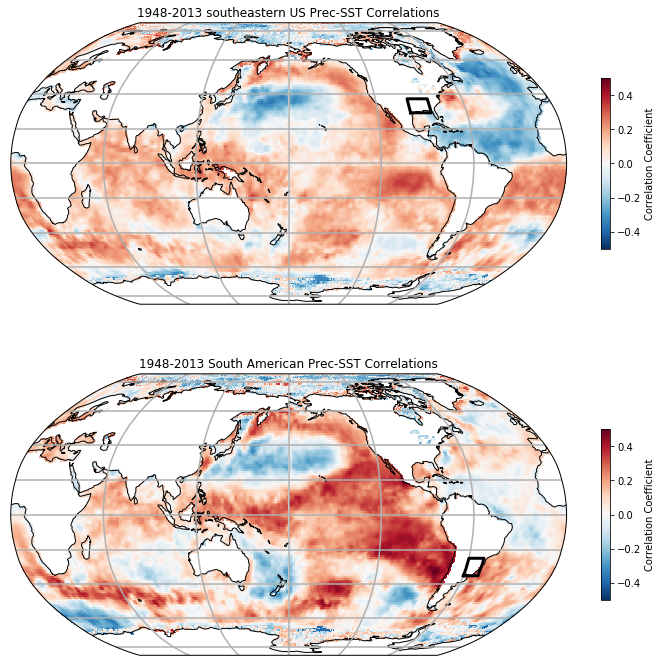

In [55]:
#Fall correlation plots for precipitation and SLP
fig = plt.figure(figsize=(10,10))  #Initialize figure size
#Initialize 2 subplots, assign to variable names ax
ax = fig.subplots(nrows=2,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})  #Robinson projection used

#Plot colormap of southeastern US correlations
cbp1 = ax[0].pcolormesh(corrSEUS.lon.values,corrSEUS.lat.values,corrSEUS.values,vmin=-.5,vmax=.5,
                        cmap='RdBu_r',transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add box outlining SE-US region
ax[0].plot([360-98,360-84,360-84,360-98,360-98],[29,29,37,37,29],'k-',linewidth=3,transform=ccrs.PlateCarree());
#Add and format colorbar
cbar1 = fig.colorbar(cbp1,ax=ax[0],shrink=.5);
cbar1.set_label('Correlation Coefficient')

#Plot colormap of South American correlations
cbp2 = ax[1].pcolormesh(corrSA.lon.values,corrSA.lat.values,corrSA.values,vmin=-.5,vmax=.5,
                        cmap='RdBu_r',transform=ccrs.PlateCarree());  #Transform: geographical to Robinson
#Add box outlining SA region
ax[1].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-',linewidth=3,transform=ccrs.PlateCarree());
#Add and format colorbar
cbar2 = fig.colorbar(cbp2,ax=ax[1],shrink=.5);
cbar2.set_label('Correlation Coefficient')

ax[0].coastlines()  #Add coastlines
ax[1].coastlines()  #Add coastlines
ax[0].gridlines(linewidth=1.5);  #Add gridlines
ax[1].gridlines(linewidth=1.5);  #Add gridlines
#Add titles
ax[0].set_title('1948-2013 southeastern US Prec-SST Correlations');
ax[1].set_title('1948-2013 South American Prec-SST Correlations');

plt.tight_layout()  #Space subplots adequately

For the __southeastern US__, high fall precipitation is associated with cooler subtropical Atlantic SSTs in the area of high sea-level pressure from the North Atlantic subtropical High.

For southeastern South America, high Southern Hemisphere spring precipitation is associated with an ENSO-like SST pattern in tropical-to-subtropical Pacific Ocean.